# Db2i Agent - LangChain Example

## Architecture

At a high-level, the steps of these systems are:

1. Convert question to SQL query: Model converts user input to a SQL query.
2. Execute SQL query: Execute the query.
3. Answer the question: Model responds to user input using the query results.

## Model

For this demo, we are using `llama3.1` with Ollama


In [2]:
from dotenv import load_dotenv
import os

def load_connection():
    connection_details = {
        "host": os.getenv("HOST"),
        "user": os.getenv("DB_USER"),
        "port": os.getenv("PORT", 8075),
        "password": os.getenv("PASSWORD"),
        "schema": os.getenv("SCHEMA"),
    }
    return connection_details

load_dotenv()
config = load_connection()
SCHEMA = os.getenv("SCHEMA")

In [3]:
from db2i_tools.database import Db2iDatabase

db = Db2iDatabase(schema=SCHEMA, server_config=config)
print(db.get_usable_table_names())

['ACT', 'AVERAGE_SALARY_PER_DEPARTMENT', 'CL_SCHED', 'DELETEMEPY', 'DEPARTMENT', 'DEPARTMENTS', 'EMPLOYEE', 'EMPLOYEES', 'EMPPROJACT', 'EMP_PHOTO', 'EMP_RESUME', 'IN_TRAY', 'ORG', 'PROJACT', 'PROJECT', 'RANDOMDATA', 'SALES', 'STAFF']


In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str



In [5]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1:latest"
)

In [6]:
test_tables = db.get_table_info(['DEPARTMENT', 'EMPLOYEE'])
print(test_tables)

--  Generate SQL
--  Version:                   V7R4M0 190621
--  Generated on:              25/03/13 18:27:31
--  Relational Database:       E7001B91
--  Standards Option:          Db2 for i

CREATE OR REPLACE TABLE SAMPLE.DEPARTMENT (
  DEPTNO CHAR(3) CCSID 273 NOT NULL ,
  DEPTNAME VARCHAR(36) CCSID 273 NOT NULL ,
  MGRNO CHAR(6) CCSID 273 DEFAULT NULL ,
  ADMRDEPT CHAR(3) CCSID 273 NOT NULL ,
  "LOCATION" CHAR(16) CCSID 273 DEFAULT NULL ,
  CONSTRAINT SAMPLE.Q_SAMPLE_DEPARTMENT_DEPTNO_00001 PRIMARY KEY( DEPTNO ) )

  RCDFMT DEPARTMENT ;

ALTER TABLE SAMPLE.DEPARTMENT
  ADD CONSTRAINT SAMPLE.ROD
  FOREIGN KEY( ADMRDEPT )
  REFERENCES SAMPLE.DEPARTMENT ( DEPTNO )
  ON DELETE CASCADE
  ON UPDATE NO ACTION ;

ALTER TABLE SAMPLE.DEPARTMENT
  ADD CONSTRAINT SAMPLE.RDE
  FOREIGN KEY( MGRNO )
  REFERENCES SAMPLE.EMPLOYEE ( EMPNO )
  ON DELETE SET NULL
  ON UPDATE NO ACTION ;
3 sample rows from DEPARTMENT:
DEPTNO	DEPTNAME	MGRNO	ADMRDEPT	LOCATION
A00	SPIFFY COMPUTER SERVICE DIV.	000010	A00	N

In [7]:
from typing_extensions import Annotated
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state):
    """
    Generate a SQL query based on the user question and database schema.
    """
    # Create prompt for SQL query generation
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                f"""You are a helpful SQL assistant that generates DB2 for i SQL queries based on user questions.
                
                Database schema:
                {test_tables}
                
                Generate a clear and efficient SQL query that answers the user's question."""
            ),
            ("human", "{question}"),
        ]
    )
    
    structured_llm = llm.with_structured_output(QueryOutput)
    chain = prompt | structured_llm
    
    result = chain.invoke({"question": state["question"]})
    
    return result


In [8]:
write_query({"question": "How many employees are in each department?"})


{'query': 'SELECT COUNT(EMPNO) , WORKDEPT FROM SAMPLE.EMPLOYEE GROUP BY WORKDEPT'}

In [9]:
from db2i_tools.tools import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [10]:
result = execute_query({"query": "SELECT COUNT(*) , DEPTNAME FROM SAMPLE.EMPLOYEE AS T1 JOIN SAMPLE.DEPARTMENT AS T2 ON T1.WORKDEPT = T2.DEPTNO GROUP BY DEPTNAME"})

In [11]:
result

{'result': "[(7, 'OPERATIONS'), (1, 'PLANNING'), (11, 'MANUFACTURING SYSTEMS'), (7, 'ADMINISTRATION SYSTEMS'), (4, 'INFORMATION CENTER'), (6, 'SOFTWARE SUPPORT'), (5, 'SPIFFY COMPUTER SERVICE DIV.'), (1, 'SUPPORT SERVICES')]"}

In [12]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}



In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

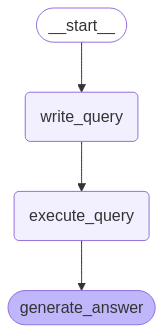

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [15]:
for step in graph.stream(
    {"question": "How many employees are in each department?"}, stream_mode="updates"
):
    print(step)



{'write_query': {'query': 'SELECT COUNT(*) , WORKDEPT FROM SAMPLE.EMPLOYEE GROUP BY WORKDEPT'}}
{'execute_query': {'result': "[(7, 'E11'), (5, 'A00'), (7, 'D21'), (4, 'C01'), (1, 'E01'), (11, 'D11'), (1, 'B01'), (6, 'E21')]"}}
{'generate_answer': {'answer': "Based on the SQL result, here's the answer to the user question:\n\nHow many employees are in each department?\n\nAccording to the results, there are:\n\n* 7 employees in Department E11\n* 5 employees in Department A00\n* 7 employees in Department D21\n* 4 employees in Department C01\n* 1 employee in Department E01\n* 11 employees in Department D11\n* 1 employee in Department B01\n* 6 employees in Department E21"}}


## Human-in-the-loop

In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=['execute_query'])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": 1}}


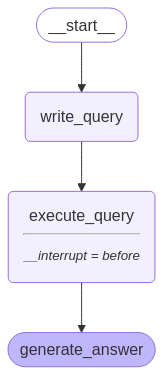

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) FROM SAMPLE.EMPLOYEE'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(42,)]'}}
{'generate_answer': {'answer': 'There are 42 employees.'}}


## Agents

Agents leverage the reasoning capabilities of LLMs to make descisions during execution. Using agents allows you to offload additional discretion over the query generation and execution process. Although their behavior is less predictable than the above "chain", they feature some advantages:

- They can query the database as many times as needed to answer the user question.
- They can recover from errors by running a generated query, catching the traceback and regenerating it correctly.
- They can answer questions based on the databases' schema as well as on the databases' content (like describing a specific table).

Below is a minimal example of an SQL agent using [`Db2iDatabaseToolkit`](db2i_tools/toolkit.py)

The `Db2iDatabaseToolkit` has tools that can:
- create an execute queries
- check query syntax
- retrieve table descriptions


In [20]:
from db2i_tools.toolkit import Db2iDatabaseToolkit

toolkit = Db2iDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<db2i_tools.database.Db2iDatabase object at 0x123931790>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<db2i_tools.database.Db2iDatabase object at 0x123931790>),
 ListSQLDatabaseTool(db=<db2i_tools.database.Db2iDatabase object at 0x123931790>),
 QuerySQLCheckerTool(description='Use this tool to double check if your query is correct before executing it. Always use this tool before 

In [21]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

/Users/adamshedivy/Documents/IBM/sandbox/oss/ai/db2i-ai/db2i-agents/examples/agents/langchain/.venv/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
system_message = prompt_template.format(dialect="Db2i", top_k=5)

In [39]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-sonnet-20240229")

agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [40]:
question = "describe the employee table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

describe the employee table
================================== Ai Message ==================================

[{'text': "Okay, let's first get a list of the tables in the database:", 'type': 'text'}, {'id': 'toolu_01X8bybPoTQkQ7DXCm1eSpdH', 'input': {'tool_input': ' '}, 'name': 'sql_db_list_tables', 'type': 'tool_use'}]
Tool Calls:
  sql_db_list_tables (toolu_01X8bybPoTQkQ7DXCm1eSpdH)
 Call ID: toolu_01X8bybPoTQkQ7DXCm1eSpdH
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

ACT, AVERAGE_SALARY_PER_DEPARTMENT, CL_SCHED, DELETEMEPY, DEPARTMENT, DEPARTMENTS, EMPLOYEE, EMPLOYEES, EMPPROJACT, EMP_PHOTO, EMP_RESUME, IN_TRAY, ORG, PROJACT, PROJECT, RANDOMDATA, SALES, STAFF
================================== Ai Message ==================================

[{'text': "The EMPLOYEE table is listed, so let's check its schema:", 'type': 't